In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gridrender as gui
import math
import os
import time
import pdb
import numbers

from gridworld import GridWorld, two_rooms_grid, two_rooms_computeOptions, four_rooms_grid
from RL_methods import PolicyLearning, ValueLearning
from HRL_methods import Option, MAXQ
from anytree import Node, PreOrderIter
from anytree.search import findall_by_attr
from anytree.render import RenderTree

%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

Populating the interactive namespace from numpy and matplotlib


In [2]:
twoRooms_grid = two_rooms_grid(room_width=10, room_height=7, doorway_pos=3, doorway_height=1, goal_height=0)

# Declaring reset density
reset_density = np.zeros((len(twoRooms_grid),len(twoRooms_grid[0])))
for i in range(reset_density.shape[0]):
    for j in range(reset_density.shape[1]):
        if twoRooms_grid[i][j] != 'x' and 'x' in twoRooms_grid[i][j:]:
            reset_density[i][j] = 1
reset_density /= reset_density.sum()

twoRooms = GridWorld(gamma=0.95, grid=twoRooms_grid, reset_density=reset_density)

fourRooms_grid = four_rooms_grid(room_width=10, room_height=7, doorway_pos_v=5, doorway_pos_h=3, doorway_height=1, goal_width=20, goal_height=12)
fourRooms = GridWorld(gamma=0.95, grid=fourRooms_grid)

## Value estimation in RL

Let's define a first policy that we will test the problem with:

In [ ]:
def policy1(state,GridWorld):
    if 0 in GridWorld.state_actions[state]:
        action = 0
    elif 3 in GridWorld.state_actions[state]:
        action = 3
    elif 1 in GridWorld.state_actions[state]:
        action = 1
    else:
        action = 2
    return action    

In [ ]:
Q4_ValEst = ValueLearning(1,twoRooms,policy1)
Q4_ValEst.run()
Q4_ValEst.render()

## Policy learning in RL

Stats from last run
Mean reward cumulated over single episode: 750.50


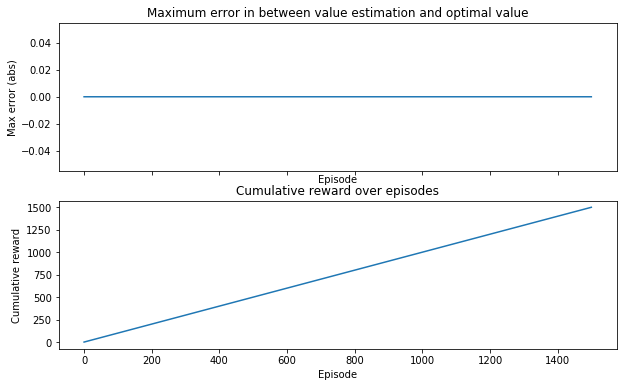

In [6]:
P = PolicyLearning(ind=0, GridWorld=twoRooms, max_iter = 1500)
P.run()
P.stats()
P.render()

gui.render_policy(P.GridWorld, P.policy)

## Hierarchical RL
### MAXQ Algorithm

We will build an option $O_{downward}$ with the following characteristics:
- non-zero probability of being triggered everywhere in the left room, above the doorway
- null probability of being triggered everywhere in the right room
- when triggered, moves downward until it reaches the level of doorway, then moves right towards it
- stops when reaching the grid element just in front of the door from the left room to the right room

Similarly, we will build the $O_{upward}$ that is exactly symmetrical of $O_{downward}$, allowing to reach the doorway from every element in the lower part of the left room.

In [3]:
[downward_initSet,upward_initSet, quitMap, downward_policy_matrix, upward_policy_matrix] = two_rooms_computeOptions(room_width=10, room_height=7, doorway_pos=3, doorway_height=1)

def downward_policy(coords):
    return downward_policy_matrix[coords[0],coords[1]]
def upward_policy(coords):
    return upward_policy_matrix[coords[0],coords[1]]

downward_option = Option(downward_initSet, downward_policy, quitMap, conceptState=70, name='Downward to doorway')
upward_option = Option(upward_initSet, upward_policy, quitMap, conceptState=70, name='Upward to doorway')

# print(downward_policy_matrix)
# print(upward_policy_matrix)
# print(downward_initSet)
# print(upward_initSet)
# print(quitMap)

In [4]:
MaxQ_2Rooms = MAXQ(twoRooms, alpha0=0.25, expl0=0.1, n_iter=500, optionSet=[downward_option, upward_option], debug=False)

Training MAXQ on 500 runs:   0%|          | 0/500 [00:00<?, ?it/s]

Root
├── right
├── down
├── left
├── up
├── Downward to doorway
│   ├── right
│   ├── down
│   ├── left
│   └── up
└── Upward to doorway
    ├── right
    ├── down
    ├── left
    └── up


Training MAXQ on 500 runs: 100%|██████████| 500/500 [03:13<00:00,  2.59it/s]


In [ ]:
pdb.pm()

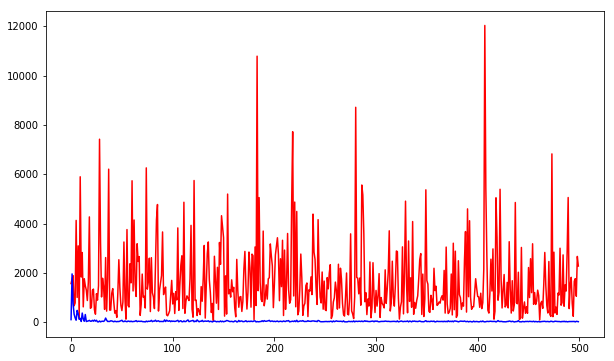

In [7]:
# plt.plot(range(max(MaxQ_2Rooms.n_iter, P.max_iter)), MaxQ_2Rooms.timeLog, 'r', range(max(MaxQ_2Rooms.n_iter, P.max_iter)), P.timeLog, 'b')
plt.plot(range(500), MaxQ_2Rooms.timeLog[:500], 'r', range(500), P.timeLog[:500], 'b')

In [ ]:
print(np.argwhere(array(twoRooms.grid) == '1').ravel())
print(np.array(twoRooms.state2coord[40]))

In [ ]:
np.linalg.norm([3,3] - np.array(twoRooms.state2coord)[[45,62,12,31,2,78,94]], axis=1) > 5

In [8]:
def static_filter(s,dist_to_goal=4):
    objective = np.array([0,len(twoRooms_grid[0])-1])
    coord_s = np.array(twoRooms.state2coord[s])
    return np.linalg.norm(objective-coord_s) >= dist_to_goal


def get_DD_map(record_trajectory, static_filter = lambda x: True):
    
    DD_map = np.zeros((len(twoRooms_grid),len(twoRooms_grid[0])))
    count = {}
    for s in range(twoRooms.n_states):
        count[s] = 0
    for traj in record_trajectory:
        seen = {}
        for x,_,_ in traj:
            if not x in seen and static_filter(x):
                i,j = twoRooms.state2coord[x]
                DD_map[i,j] += 1
                seen[x] = True
    
    return DD_map

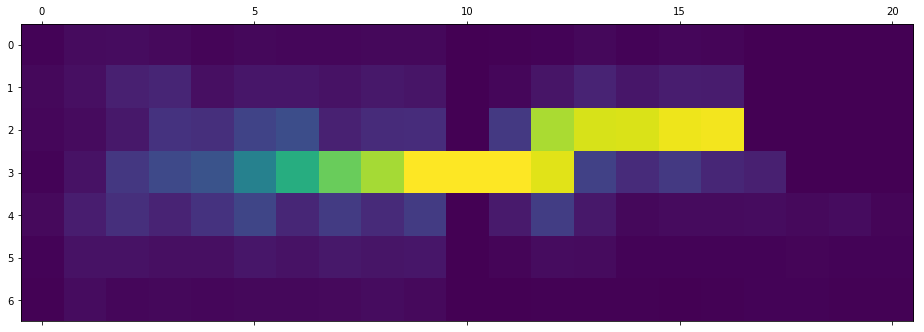

In [9]:
DD_map_RL = get_DD_map(P.trajLog, static_filter)
plt.matshow(DD_map_RL)
plt.show()

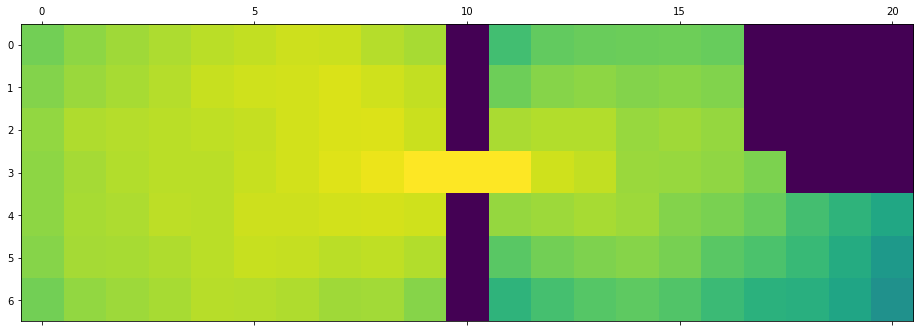

In [10]:
DD_map_HRL = get_DD_map(MaxQ_2Rooms.trajLog, static_filter)
plt.matshow(DD_map_HRL)
plt.show()

In [12]:
MaxQ_2Rooms.policy

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0])